<a href="https://colab.research.google.com/github/MariaMengozzi/esameDI/blob/main/Progetto_esame_DI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Determinare il prezzo di vendita delle auto

**Programmazione di Applicazioni Data Intensive**\
Laurea in Ingegneria e Scienze Informatiche\
DISI - Università di Bologna, Cesena

Maria Mengozzi

Per prima cosa carichiamo le librerie necessarie ad elaborare i dati:


*   *os.path* per elaborare i percorsi dei file
*   *NumPy* per creare e operare su array N dimesionali
*   *pandas* per caricare e manipolare dati tabulari
*   *matplotlib* e *seaborn* per creare grafici, viene inoltre aggiunta il comando per visualizzarli all'interno del notebook.


In [153]:
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1 - Descrizione del problema, comprensione e analisi esplorativa dei dati


## Descrizione del problema

Carichiamo il dataset da [Kaggle](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv) contenente le informazioni sulle auto usate elencate su [www.cardekho.com](www.cardekho.com). 

L' obiettivo del progetto è quello di predire una variabile continua, ossia il prezzo di vendita di un' auto usata in base alle sue caratteristiche.

In [154]:
file_zip_url = "https://github.com/MariaMengozzi/esameDI/raw/main/UsedCarsDataset.zip"
file_zip_name = "UsedCarsDataset.zip"
file_name = 'Car details v3.csv'

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

In [155]:
with open(file_name) as dataFile:
    data = pd.read_csv(dataFile, sep=",")

## Comprensione dei dati e analisi esplorativa

Analizziamo ora i dati. 

Il dataset contiene:

In [156]:
data.shape

(8128, 13)

In [157]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


Le 13 **feature** presenti nel dataset sono:

* `name` : nome dell'auto
* `year` : anno in cui l'auto è stata comprata la prima volta
*	`km_driven` : numero di chilometri percorsi dall'auto
*	`fuel` : tipo di carburante utilizzato dall'auto
*	`seller_type`	: indica se l'auto è venduta da un privato o un rivenditore
* `transmission` : tipo di trasmissione dell'auto (automatico o manuale)
* `owner` : numero di proprietari precedenti
* `mileage`	: distanza per unità di carburante
* `engine` :  cilindrata dell'auto
* `max_power`	: potenza massima del motore
* `torque`	: coppia motore, ovvero quanta potenza ci vuole perché l'auto raggiunga una certa velocità.
* `seats` : numero di sedili nell'auto

La variabile che tenteremo di predire è:
*	`selling_price` : prezzo di vendita dell'auto




Osserviamo ora la tipologia delle variabili, in modo da capire se è possibile risparmiare spazio in memoria

In [158]:
data.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object

In [159]:
data.info(verbose=False, memory_usage="deep");

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Columns: 13 entries, name to seats
dtypes: float64(1), int64(3), object(9)
memory usage: 5.0 MB


Come si può notare, molte delle feature sono rappresentate da oggetti. Osservando però il dataset si nota che è possibile gestire alcuni dati come categorici, nello specifico `seller_type`, `transmission`, `fuel` e `owner`. Verifichiamo ora i valori che possono assumere tali feature.




In [160]:
data['seller_type'].value_counts()

Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: seller_type, dtype: int64

In [161]:
data['transmission'].value_counts()

Manual       7078
Automatic    1050
Name: transmission, dtype: int64

In [162]:
data['fuel'].value_counts()

Diesel    4402
Petrol    3631
CNG         57
LPG         38
Name: fuel, dtype: int64

In [163]:
data['owner'].value_counts()

First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: owner, dtype: int64

Ricarichiamo quindi il dataset specificando quali dati gestire come categorici.

In [164]:
categorical = ["seller_type", "transmission", "fuel", 'owner']
with open(file_name) as dataFile:
    data = pd.read_csv(dataFile, sep=",",  dtype={x:"category" for x in categorical})

print(data.info(verbose=False, memory_usage="deep"))
print()
print(data.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Columns: 13 entries, name to seats
dtypes: category(4), float64(1), int64(3), object(5)
memory usage: 3.0 MB
None

name               object
year                int64
selling_price       int64
km_driven           int64
fuel             category
seller_type      category
transmission     category
owner            category
mileage            object
engine             object
max_power          object
torque             object
seats             float64
dtype: object


Si può notare come già la dimensione sia diminuita.

## Rilevazione di valori mancanti

Verifichiamo ora se sono presenti valori mancanti

In [165]:
data.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

Procediamo rimuovendo i valori mancanti trovati nelle feature `mileage`, `engine`, `max_power`, `torque` e `seats`

In [166]:
data.dropna(inplace=True)
#verifichiamo che siano stati rimossi
data.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           0
seats            0
dtype: int64

In [167]:
data.head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
5,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
6,Maruti Wagon R LXI DUO BSIII,2007,96000,175000,LPG,Individual,Manual,First Owner,17.3 km/kg,1061 CC,57.5 bhp,"7.8@ 4,500(kgm@ rpm)",5.0
7,Maruti 800 DX BSII,2001,45000,5000,Petrol,Individual,Manual,Second Owner,16.1 kmpl,796 CC,37 bhp,59Nm@ 2500rpm,4.0
8,Toyota Etios VXD,2011,350000,90000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.1 bhp,170Nm@ 1800-2400rpm,5.0
9,Ford Figo Diesel Celebration Edition,2013,200000,169000,Diesel,Individual,Manual,First Owner,20.0 kmpl,1399 CC,68.1 bhp,160Nm@ 2000rpm,5.0


## Conversione del tipo di dato

Osservando sempre il dataset ci si accorge che i valori di alcune feature potrebbero essere considerati come numerici se si togliesse l'unità di misura. Le feature in questione sono:
* `mileage`
* `engine`
* `max_power`
* `torque` per quest'ultima sarà necessario isolare il valore del Nm (Newton*Metro) in quanto solo tale valore rappresenta la vera e propria coppia dell'auto

Procediamo quindi rimuovendo l'unità di misura e cambiando il tipo di dato.

In [168]:
data.mileage = data.mileage.str.replace(' kmpl','')
data.mileage = data.mileage.str.replace(' km/kg','')
data.engine = data.engine.str.replace(' CC','')
data.max_power = data.max_power.str.replace(' bhp','')
#per la coppia motore estraiamo il primo valore numerico
data['torque'] = data.torque.str.extract('(\d+[.\d]*)')

In [169]:
data.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4,1248,74,190,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7,1497,78,12.7,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0,1396,90,22.4,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1,1298,88.2,11.5,5.0


In [170]:
#convertiamo ora i dati da oggetto al tipo numerico più opportuno
data['mileage'] = data.mileage.astype(float)
data['engine'] = data.engine.astype(int)
data['max_power'] = data.max_power.astype(float)
data['torque'] = data.torque.astype(float)
# poichè i posti in auto non possono essere valori floating point li convertiamo ad intero
data['seats'] = data.seats.astype(int)

In [171]:
print(data.info(verbose=False, memory_usage="deep"))
print()
print(data.dtypes)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7906 entries, 0 to 8127
Columns: 13 entries, name to seats
dtypes: category(4), float64(3), int64(5), object(1)
memory usage: 1.2 MB
None

name               object
year                int64
selling_price       int64
km_driven           int64
fuel             category
seller_type      category
transmission     category
owner            category
mileage           float64
engine              int64
max_power         float64
torque            float64
seats               int64
dtype: object


Abbiamo così ottenuto una riduzione della dimensione del dataset da 5.0 MB iniziali a 1.2 MB, assegnando ad ogni feature il tipo di dato più opportuno a rappresentarla

In [172]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,5
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,5
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,5
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,5
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,5


## Analisi generale dei dati

Visualizziamo alcune statistiche per prendere coscienza dei dati che dovremo analizzare e delle caratteristiche del dominio applicativo.

Vediamo come prima cosa quanto variano i dati in nostro possesso:

In [173]:
val_unici = []
for x in data.columns:
    val_unici.append(data[x].nunique())
pd.Series(val_unici, index=data.columns)

name             1982
year               27
selling_price     670
km_driven         898
fuel                4
seller_type         3
transmission        2
owner               5
mileage           381
engine            121
max_power         318
torque            244
seats               9
dtype: int64

Aggiungiamo una feature `years_driven` indicante gli anni che l'auto è in circolazione rispetto l'anno corrente (2021).

In [174]:
current_year = 2021
years_driven = 2021 - data['year']
data['years_driven'] = years_driven

In [175]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,years_driven
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,5,7
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,5,7
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,5,15
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,5,11
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,5,14


Per capire meglio i dati visualizziamone su dei grafici opportuni

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


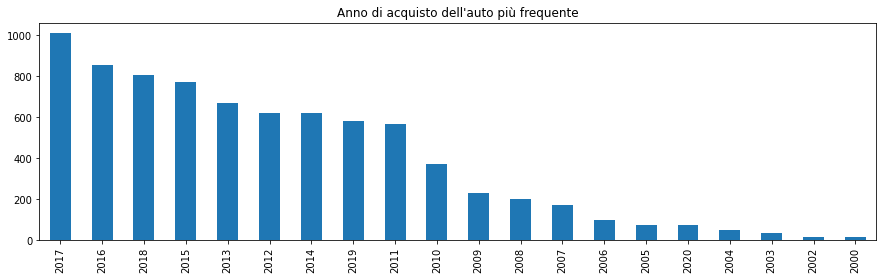

In [176]:
data['year'].value_counts()[:20].plot.bar(figsize=(15, 4));
plt.axes().set_title("Anno di acquisto dell'auto più frequente");

Notiamo che l'anno di primo acquisto, il 2017 è l'anno in cui sono state acquistate più auto.

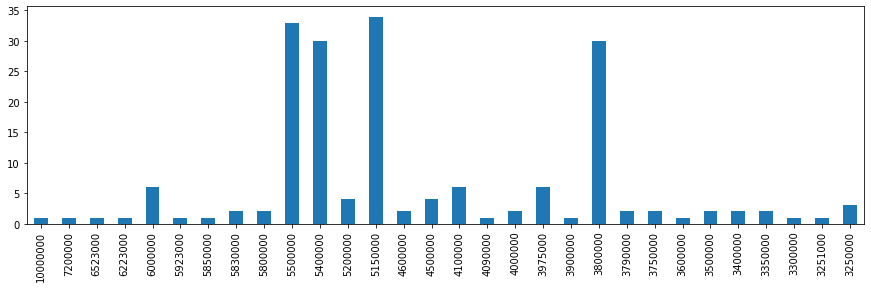

In [177]:
data["selling_price"].value_counts().sort_index(ascending=False)[:30].plot.bar(figsize=(15, 4));

Per il prezzo di vendita, ovvero la feature da predire, si può notare come i prezzi varino molto tra le auto vendute

### Numero di posti auto

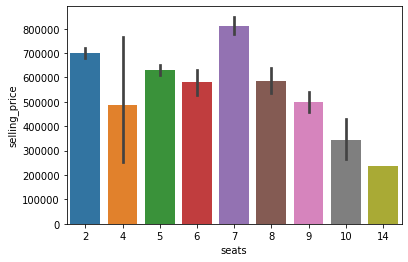

In [178]:
#data['seats'].value_counts()[:20].plot.bar(figsize=(15, 4));
#plt.axes().set_title("Posti auto");

sns.barplot(x='seats',y='selling_price',data=data)

Notiamo che Le auto con 7 posti hanno un prezzo di vendita più elevato rispetto alle altre, sono poi seguite da quelle da 2 posti e da 5. Quelle vendute ad un prezzo più basso risultano con 14 posti.

### Numero di precedenti proprietari

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


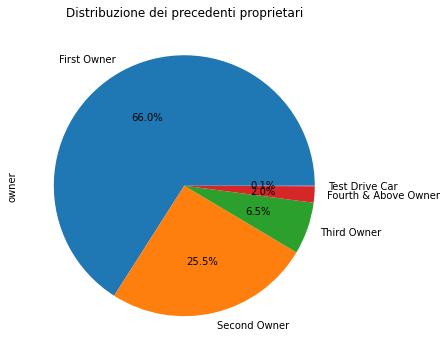

In [179]:
plt.figure(figsize=(10,6));
data['owner'].value_counts().plot.pie(autopct='%1.1f%%');
plt.axes().set_title('Distribuzione dei precedenti proprietari');

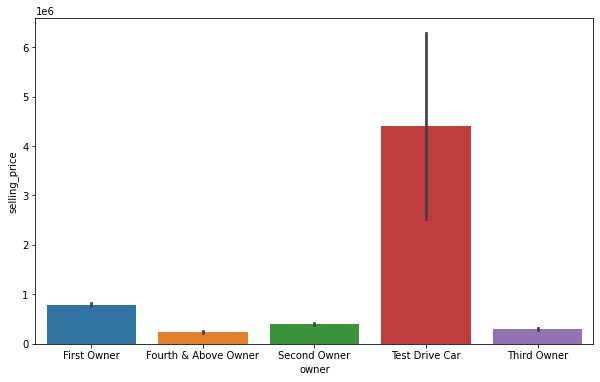

In [180]:
plt.figure(figsize=(10,6))
sns.barplot(x='owner',y='selling_price',data=data);

E' possibile notare come le auto del dataset abbiano avuto principalmente un solo proprietario prima di essere rivendute, ma che quelle vendute ad un prezzo maggiore risultano le test drive.

### Tipo di venditore

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


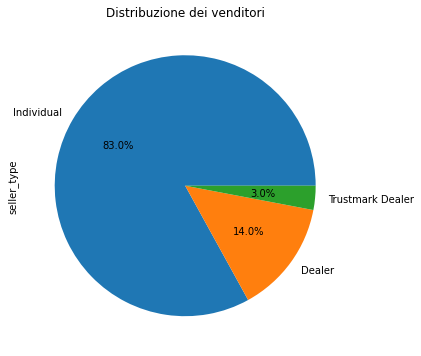

In [181]:
plt.figure(figsize=(10,6))
data['seller_type'].value_counts().plot.pie(autopct='%1.1f%%');
plt.axes().set_title('Distribuzione dei venditori');

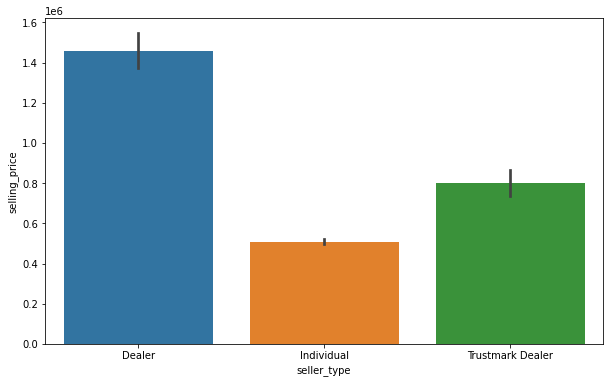

In [182]:
plt.figure(figsize=(10,6))
sns.barplot(x='seller_type',y='selling_price',data=data);

Vediamo una netta predominanza di venditori privati e solo una piccola percentuale di rivenditori di marchi di fiducia. Il prezzo di vendita delle auto risulta però maggiore nel caso dei rivenditori piuttosto che per i privati.

### Tipo di cambio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


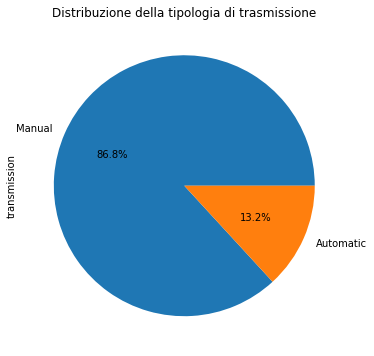

In [183]:
plt.figure(figsize=(10,6))
data['transmission'].value_counts().plot.pie(autopct='%1.1f%%');
plt.axes().set_title('Distribuzione della tipologia di trasmissione');

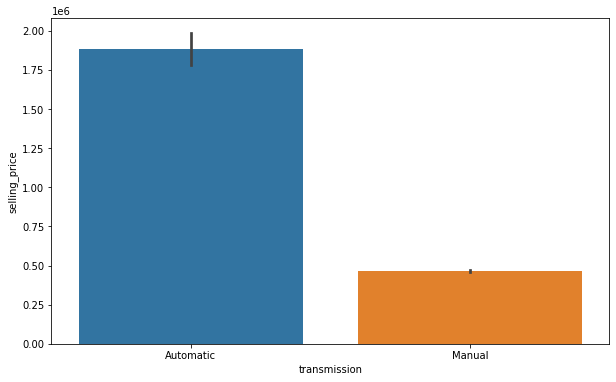

In [184]:
plt.figure(figsize=(10,6))
sns.barplot(x='transmission',y='selling_price',data=data);

Notiamo che la maggior parte delle auto vendute avevano un cambio manuale, ma che il loro prezzo di vendita è nettamente inferiore rispetto a quelle a cambio automatico.

### Tipo di carburante

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


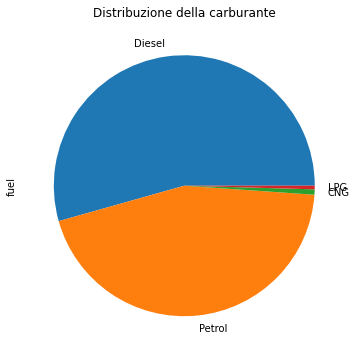

In [185]:
plt.figure(figsize=(10,6))
data['fuel'].value_counts().plot.pie();
plt.axes().set_title('Distribuzione della carburante');

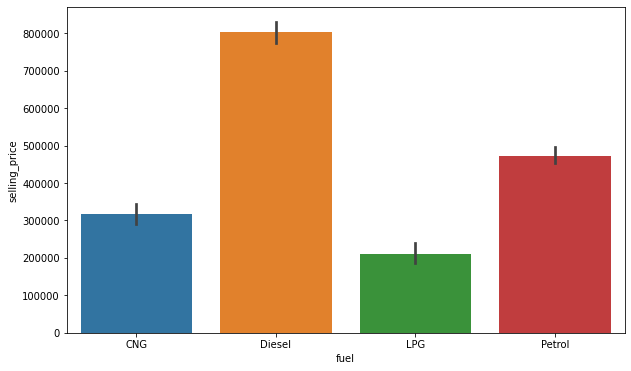

In [186]:
plt.figure(figsize=(10,6))
sns.barplot(x='fuel', y='selling_price', data = data);

Non vi è una siglificativa differenza tra auto a Diesel e Benzina le quali hanno un prezzo di vendita maggiore, mentre vi è una netta minoranza di CNG (Metano) e LPG (GPL). 

### Chilometraggio - prezzo di vendita

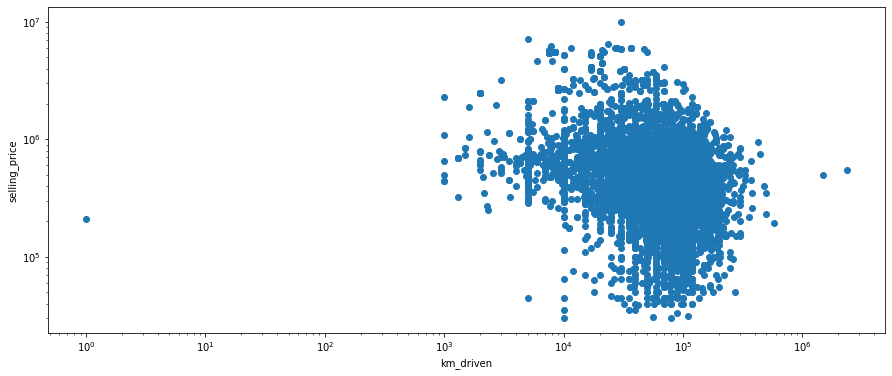

In [187]:
#essendo sia il prezzo che i chilometri sull'ordine delle migliaia, 
#utilizzo la scala logaritmica per visualizzare il grafico
plt.figure(figsize=(15,6))
plt.xscale('log')
plt.yscale('log')
plt.scatter(data['km_driven'],data['selling_price']);
plt.xlabel('km_driven');
plt.ylabel('selling_price');

Notiamo un'elevata concentrazione di prezzi sull'ordine di $10^6$ per auto con un chilometraggio intorno a 100.000km

### Anni di circolazione - prezzo di vendita

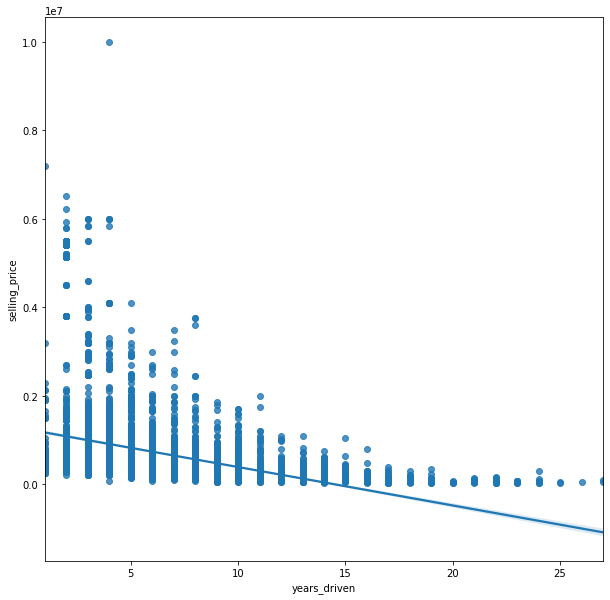

In [188]:
plt.figure(figsize=(10,10))
sns.regplot(x='years_driven',y='selling_price',data=data);

Mettendo a confronto gli anni di circolazione dell'auto e il prezzo di vendita è possibile notare come più gl'anni aumentino e più il prezzo diventi inferiore.

### Statistiche decrittive

In [189]:
data.describe()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,years_driven
count,7906.000000,7.906000e+03,7.906000e+03,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000
mean,2013.983936,6.498137e+05,6.918866e+04,19.419861,1458.708829,91.587374,168.294141,5.416393,7.016064
std,3.863695,8.135827e+05,5.679230e+04,4.036263,503.893057,35.747216,97.313384,0.959208,3.863695
min,1994.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,32.800000,4.800000,2.000000,1.000000
25%,2012.000000,2.700000e+05,3.500000e+04,16.780000,1197.000000,68.050000,101.000000,5.000000,4.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,82.000000,154.900000,5.000000,6.000000
75%,2017.000000,6.900000e+05,9.542500e+04,22.320000,1582.000000,102.000000,202.000000,5.000000,9.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,789.000000,14.000000,27.000000


Passiamo ora a visualizzare la distribuzione dei dati

Prendendo in considerazione le statistiche notiamo che:

*  l'auto più vecchia è del 1994, il che fa si che gli anni di circolazione siano pari a 27 (max(years_driven)), mente quella più recente è del 2020, con solo un anno di circolazione.
*   il prezzo medio di vendita è pari 649813. Tale feature ha un massimo pari a 10.000.000 e un minimo di 2999.
* per quanto riguarda il chilometraggio delle auto mediamente è pari a 69188 km, mentre il consumo medio al chilometro è di 19,4 l/km

Visualizziamo tali dati mediante un boxplot



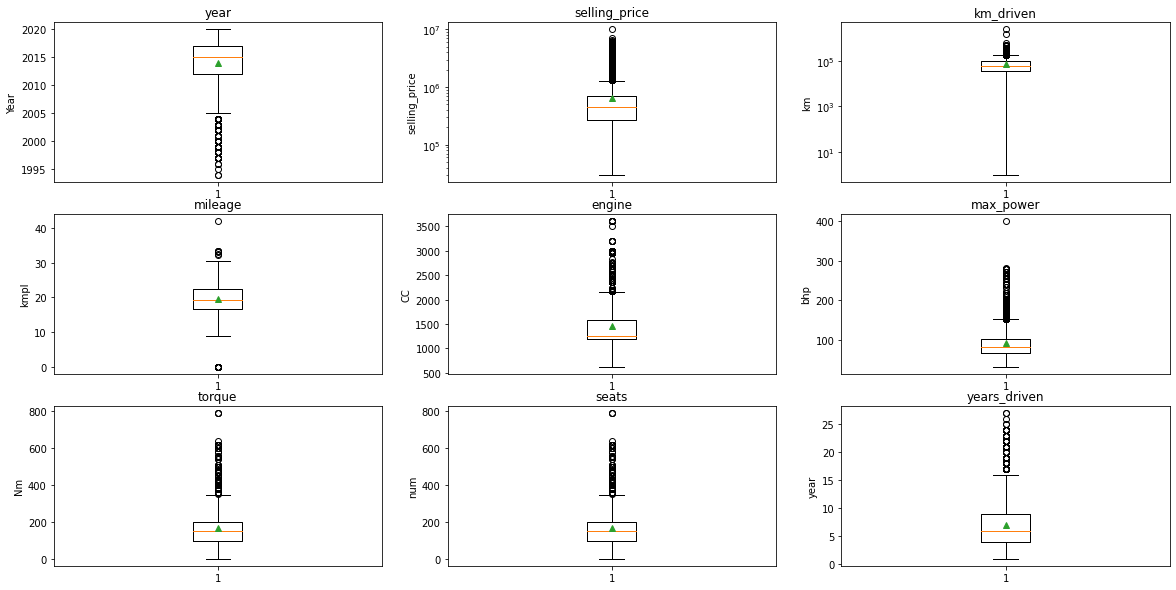

In [190]:
plt.figure(figsize=(20, 10))

plt.subplot(3, 3, 1)
plt.title('year')
plt.boxplot(data['year'],showmeans=True)
plt.ylabel('Year')

plt.subplot(3, 3, 2)
plt.title('selling_price')
plt.yscale('log')
plt.boxplot(data['selling_price'],showmeans=True)
plt.ylabel('selling_price')

plt.subplot(3, 3, 3)
plt.title('km_driven')
plt.yscale('log')
plt.boxplot(data['km_driven'],showmeans=True)
plt.ylabel('km')

plt.subplot(3, 3, 4)
plt.title('mileage')
plt.boxplot(data['mileage'],showmeans=True)
plt.ylabel('kmpl')

plt.subplot(3, 3, 5)
plt.title('engine')
plt.boxplot(data['engine'],showmeans=True)
plt.ylabel('CC')

plt.subplot(3, 3, 6)
plt.title('max_power')
plt.boxplot(data['max_power'],showmeans=True)
plt.ylabel('bhp')

plt.subplot(3, 3, 7)
plt.title('torque')
plt.boxplot(data['torque'],showmeans=True)
plt.ylabel('Nm')

plt.subplot(3, 3, 8)
plt.title('seats')
plt.boxplot(data['torque'],showmeans=True)
plt.ylabel('num')

plt.subplot(3, 3, 9)
plt.title('years_driven')
plt.boxplot(data['years_driven'],showmeans=True)
plt.ylabel('year')

plt.show()

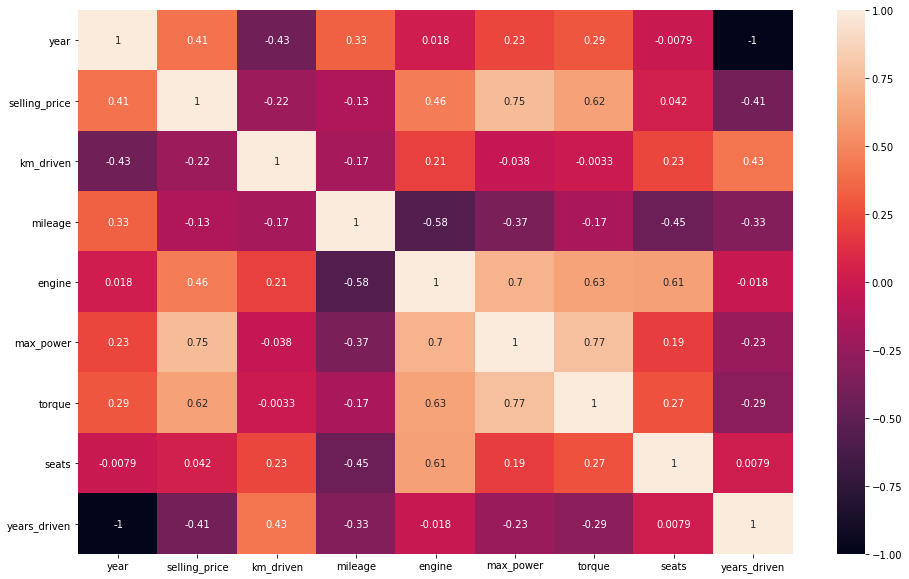

In [191]:
#plotting the heatmap
plt.figure(figsize=(16,10))
sns.heatmap(data.corr(),annot=True)
plt.show()

Producendo una matrice di correlazione delle features, possiamo osservare le seguenti correlazioni rilevanti:
* `selling_price` è correlato positivamente con `year`, `torque`, `max_power` e `engine`, al contrario sembra avere una correlazione negativa con `km_diven` e `mileage`.
* Come ci si poteva aspettare vi è un'elevata correlazione tra `max_power` e `engine`. La cilindrata, infatti, misura il volume d'aria teoricamente aspirato durante un ciclo fisico da una macchina volumetrica (il cilindro), più aria entra e più sarà elevata la potenza che il motore produce.
* Un'elevata correlazione è presente anche tra `max_power` e `torque`, ma anche questa deriva dal rapporto fisico tra le due feature. Infatti la potenza del motore è data da $Potenza = coppia * velocita' $
* Infine i chilometri percorsi `km_driven` dipendono, come ci si aspettava dall'anno in cui l'auto è stata acquistata `year` e quindi anche dagl'anni che l'auto è in circolazione `years_driven`.

# 2- Elaborazione delle features

In base alle considerazioni effettuate sulla base della correlazione, si decide di rimuovere la feature `seats` in quanto essere quella che incide in maniera minore sul prezzo di vendita dell'auto. Essendo inoltre il nome delle auto ad alta variabilità, si decide di rimuoverlo dal dataset.

In [192]:
data.drop(columns='seats', inplace=True)
data.drop(columns='name', inplace=True)

In [193]:
data.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,years_driven
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,7
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,7
2,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,15
3,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,11
4,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,14


## Binarizzazione dei dati categorici
Procediamo ora a binarizzare i dati categorici, questo ci permetterà di poterli confrontare con gli altri dati e successivamente per la generazione dei modelli

La binarizzazione avverrà mediante il metodo **One Hot Encoding**

One Hot Encoding è un processo nell'elaborazione dei dati che viene applicato ai dati categoriali, per convertirli in una rappresentazione vettoriale binaria da utilizzare negli algoritmi di apprendimento automatico.

Si convertono ora le features categoriche splittando i loro valori nelle rispettive classi di appartenenza creando una colonna per ogni classe. Nelle celle sarà presente un 1 solo in corrispondenza della classe di appartenenza e 0 negli altri casi.

In [194]:
from sklearn.preprocessing import OneHotEncoder # per applicare la binarizzazione delle variabili categoriche
#from sklearn.compose import ColumnTransformer #per applicare preprocessing differenziato

In [195]:
encoder = OneHotEncoder(sparse=False) 
# per il momento non specifico drop='first' in quanto valuterò mediante Lasso se è necessario rimuovere tali features
X_cat = data[categorical]

categorical_df = pd.DataFrame(
    encoder.fit_transform(X_cat),
    columns=encoder.get_feature_names(X_cat.columns)
)
categorical_df.head(5)

,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Utilizziamo una heatmap per visualizzare la correlazione tra le variabili del dataset finale. Lo stesso risultato ottenuto con OneHotEncoded è ottenibile con pd.get_dummies()

In [196]:
final_data = pd.get_dummies(data) 
#poichè utilizzerò la regolarizzazione al momento non specifico drop_firt=True, successivamente se necessario rimuoverò tali feature
final_data.head()

,year,selling_price,km_driven,mileage,engine,max_power,torque,years_driven,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2014,450000,145500,23.40,1248,74.00,190.0,7,0,1,0,0,0,1,0,0,1,1,0,0,0,0
1,2014,370000,120000,21.14,1498,103.52,250.0,7,0,1,0,0,0,1,0,0,1,0,0,1,0,0
2,2006,158000,140000,17.70,1497,78.00,12.7,15,0,0,0,1,0,1,0,0,1,0,0,0,0,1
3,2010,225000,127000,23.00,1396,90.00,22.4,11,0,1,0,0,0,1,0,0,1,1,0,0,0,0
4,2007,130000,120000,16.10,1298,88.20,11.5,14,0,0,0,1,0,1,0,0,1,1,0,0,0,0


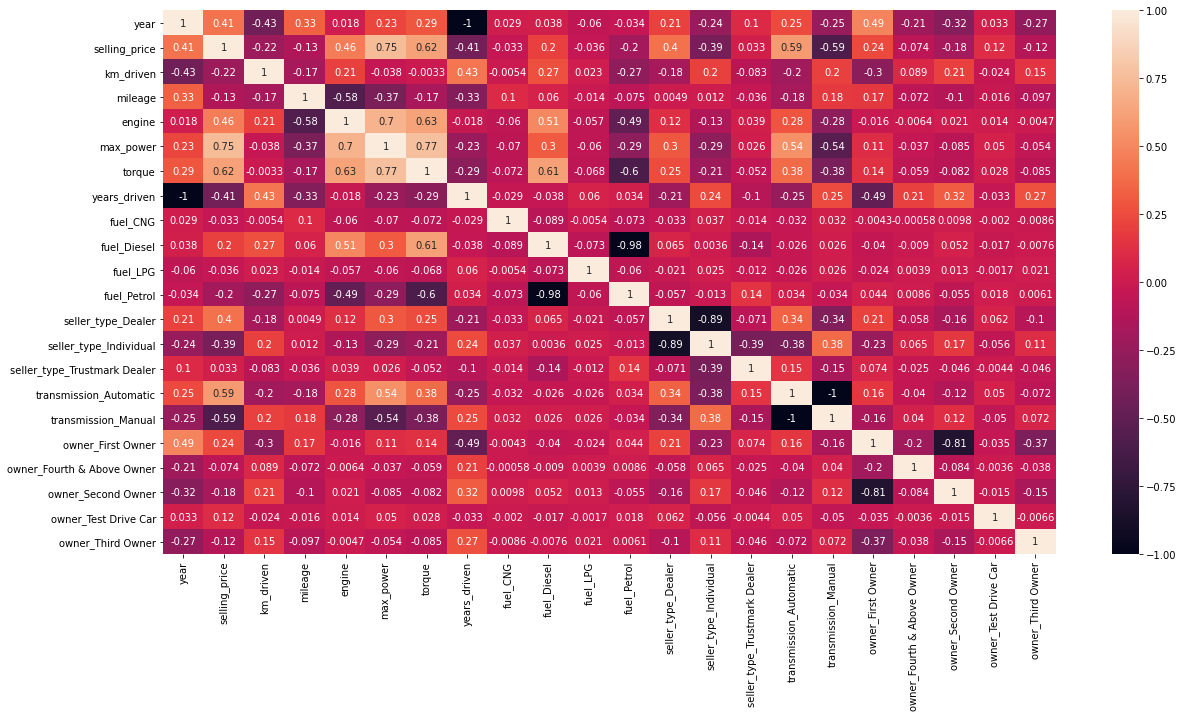

In [197]:
#plotting the heatmap
plt.figure(figsize=(20,10))
sns.heatmap(final_data.corr(),annot=True)
plt.show()

Analizzando la correlazione tra `selling_price` e  le variabili categoriche è possibile constatare che le auto che hanno avuto un solo proprietario hanno una correlazione positiva con il prezzo di vendita, così pure il cambio automatico, il diesel e come venditore un rivenditore, mentre il cambio manuale, la vendita da parte di un privato e gli anni di circolazione dell'auto hanno una correlazione negativa.

Prendiamo in considerazione soprattutto la variabile da predire `selling_price` e analizziamo la correlazione con le altre variabili.

Notiamo che le features maggiormente correlate con la nostra variabile sono i cilindri dell'auto, la potenza, la coppia motore, il tipo di cambio automatico. al contrario notiamo che quelle che sono meno correlate sono il cambio manuale, gli anni di circolazione e il tipo di venditore privato.


Utilizziamo ora la funzione pairplot di seaborn per comprendere la relazione tra le features e la variabile da predire.

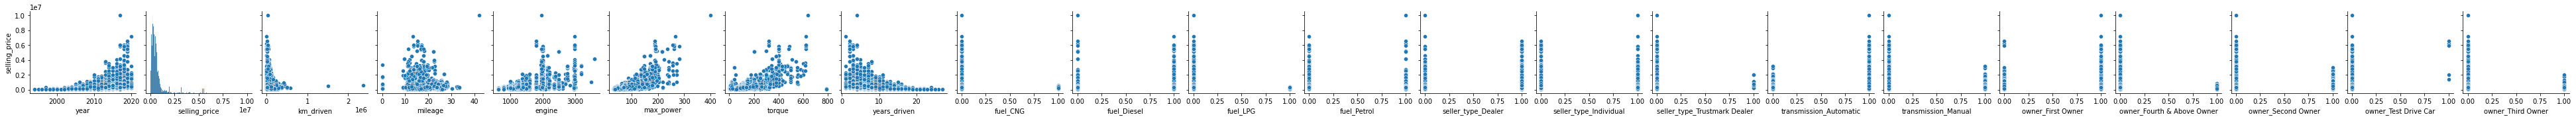

In [198]:
sns.pairplot(final_data, 
            y_vars=["selling_price"])

## Standardizzazione, Regolarizzarione e selezione delle feature

Poichè le istanze del dataset hanno ordini di grandezza diversi si procede anche alla standardizzazione delle feature mediante StandardScaler al fine di uniformare i valori.

A seguito di alcune prove eseguite sul dataset è stato deciso di applicare la standardizzazione a tutte le variabili indipendenti e non solo a quelle numeriche, in quanto applicandole alle solo variabili numeriche si è visto che i coefficienti aumentavano e l'accuratezza del modello diminuiva.

Importiamo come prima cosa le librerie necessarie.

In [199]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Dividiamo mediante il metodo di hold out i dati in training e validation set, assegnando al validation set 1/3 e al training set 2/3 dei dati

In [200]:
#poichè il prezzo di vendita ha valori multipli di 10.000 lo divido per tale valore
y = final_data['selling_price'] //10000
X = final_data.drop(columns="selling_price")

In [201]:
y.head()

0    45
1    37
2    15
3    22
4    13
Name: selling_price, dtype: int64

In [202]:
X.head()

,year,km_driven,mileage,engine,max_power,torque,years_driven,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2014,145500,23.40,1248,74.00,190.0,7,0,1,0,0,0,1,0,0,1,1,0,0,0,0
1,2014,120000,21.14,1498,103.52,250.0,7,0,1,0,0,0,1,0,0,1,0,0,1,0,0
2,2006,140000,17.70,1497,78.00,12.7,15,0,0,0,1,0,1,0,0,1,0,0,0,0,1
3,2010,127000,23.00,1396,90.00,22.4,11,0,1,0,0,0,1,0,0,1,1,0,0,0,0
4,2007,120000,16.10,1298,88.20,11.5,14,0,0,0,1,0,1,0,0,1,1,0,0,0,0


In [203]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.3, random_state=42)

Ora che il dataset è stato diviso procediamo alla creazione e alla valutazione dei modelli al fine di avere una prima conoscenza sulle feature più importanti per il modello.

In [204]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [205]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [206]:
'''R2_train_cross_validate = []
R2_train = []
R2_test = []'''

#definiamo la metodologia di cross-validation da applicare 
kf = KFold(5, shuffle=True, random_state=42)

def pred_model(model):
    # Training model
    model.fit(X_train,y_train)
            
    # R2 score of train set
    y_pred_train = model.predict(X_train)
    R2_train_model = r2_score(y_train,y_pred_train)
    #R2_train.append(round(R2_train_model,2))
    
    # R2 score of test set
    y_pred_val = model.predict(X_val)
    R2_test_model = r2_score(y_val,y_pred_val)
    #R2_test.append(round(R2_test_model,2))
    
    # R2 mean of train set using Cross validation
    cross_val = cross_val_score(model, X_train , y_train ,cv=kf)
    cv_mean = cross_val.mean()
    #R2_train_cross_validate.append(round(cv_mean,2))
    
    # Printing results
    #print("Mean squared error :",round(mean_squared_error(y_val, y_pred_val),2))
    print("Relative error : ",round(relative_error(y_val, y_pred_val),2))
    print("Train R2-score :",round(R2_train_model,2))
    print("Test R2-score :",round(R2_test_model,2))
    print("Train CV scores :",cross_val)
    print("Train CV mean :",round(cv_mean,2))
    print(pd.Series(model.named_steps['reg'].coef_, X_train.columns))
    
    '''
    # Plotting Graphs 
    # Differenza tra il prezzo di vendita predetto e quello reale sul training set
    fig, ax = plt.subplots(1,2,figsize = (15,4))
    ax[0].set_title('Differenza tra il prezzo di vendita predetto e quello reale sul training set')
    sns.distplot((y_train-y_pred_train),hist = False,ax = ax[0])
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('y_train - y_pred_train')
    
    # Y_test vs Y_train scatter plot
    ax[1].set_title('y_val vs y_pred_test')
    ax[1].scatter(x = y_val, y = y_pred_test)
    ax[1].set_xlabel('y_val')
    ax[1].set_ylabel('y_pred_test')
    
    plt.show()'''

Iniziamo costruendo un modello lineare a cui applichiamo la standardizzazione dei dati.

In [207]:
linear_model = Pipeline([
                   ('scaler', StandardScaler()),
                   ('reg', LinearRegression())
])

pred_model(linear_model)

Relative error :  0.76
Train R2-score : 0.68
Test R2-score : 0.69
Train CV scores : [0.66154165 0.66616681 0.66985598 0.6891082  0.68921526]
Train CV mean : 0.68
year                            7.025806e+13
km_driven                      -7.398438e+00
mileage                         6.169197e+00
engine                          3.286898e+00
max_power                       4.489391e+01
torque                          2.423896e+00
years_driven                    7.025806e+13
fuel_CNG                       -1.042847e+12
fuel_Diesel                    -6.742812e+12
fuel_LPG                       -9.438050e+11
fuel_Petrol                    -6.727388e+12
seller_type_Dealer             -1.097342e+13
seller_type_Individual         -1.189461e+13
seller_type_Trustmark Dealer   -5.436941e+12
transmission_Automatic          1.119626e+11
transmission_Manual             1.119626e+11
owner_First Owner               9.096593e+13
owner_Fourth & Above Owner      2.639174e+13
owner_Second Owner          

Si può notare come i coefficienti del modello sono molto elevati, applichiamo quindi la regolarizzazione L2 mediante la regressione Ridge, proviamo con $alpha=10$

In [208]:
ridge_model_10 = Pipeline([
                   ('scaler', StandardScaler()),
                   ('reg', Ridge(alpha=10, random_state=42))
])

pred_model(ridge_model_10)

Relative error :  0.75
Train R2-score : 0.68
Test R2-score : 0.69
Train CV scores : [0.66195969 0.6662351  0.66993119 0.68883284 0.68902395]
Train CV mean : 0.68
year                             5.569966
km_driven                       -7.349982
mileage                          6.156069
engine                           3.398927
max_power                       44.573352
torque                           2.602150
years_driven                    -5.569966
fuel_CNG                         0.365394
fuel_Diesel                      0.447933
fuel_LPG                         1.759663
fuel_Petrol                     -0.752470
seller_type_Dealer               4.940106
seller_type_Individual          -3.196954
seller_type_Trustmark Dealer    -2.976556
transmission_Automatic           7.723501
transmission_Manual             -7.723501
owner_First Owner                0.936285
owner_Fourth & Above Owner       0.805887
owner_Second Owner              -1.354764
owner_Test Drive Car             5.37198

Si può notare come l'indice $R^2$ con la regolarizzazione non cambi più di tanto, mentre ol valore dei coefficienti è diminuto notevolmente, permettendoci di individuare più facilmente le feature più importanti per la predizione del prezzo di vendita.

Proviamo a ripetere la Ridge con un valore più elevato di $alpha$ in modo da ottenere dei coefficienti ancora più piccoli.

In [209]:
ridge_model_100 = Pipeline([
                   ('scaler', StandardScaler()),
                   ('reg', Ridge(alpha=100, random_state=42))
])

pred_model(ridge_model_100)

Relative error :  0.74
Train R2-score : 0.68
Test R2-score : 0.69
Train CV scores : [0.6648258  0.66627693 0.66938542 0.6866288  0.68796679]
Train CV mean : 0.68
year                             5.595073
km_driven                       -7.245078
mileage                          5.938769
engine                           4.224867
max_power                       41.963882
torque                           4.152155
years_driven                    -5.595073
fuel_CNG                         0.378294
fuel_Diesel                      0.155613
fuel_LPG                         1.729667
fuel_Petrol                     -0.457271
seller_type_Dealer               5.002827
seller_type_Individual          -3.257821
seller_type_Trustmark Dealer    -2.969986
transmission_Automatic           7.910434
transmission_Manual             -7.910434
owner_First Owner                0.948885
owner_Fourth & Above Owner       0.777489
owner_Second Owner              -1.372370
owner_Test Drive Car             5.31931

Anche in questo caso il valore dell'indice $R^2$ è rimasto pressochè costante, diminuendo ulteriormente il valore dei coefficienti assegnati alle feature. 

Proviamo ora a verificare se è possibile addestrare un modello meno complesso mediante la selezione delle feature. Utilizzeremo la regressione lasso per verificare se sono presenti delle feature meno rilevanti. Come prima prova impostiamo il valore di L1 ($alpha$) pari a 0,5


In [210]:
lasso_model_05 = Pipeline([
                   ('scaler', StandardScaler()),
                   ('reg', Lasso(alpha=0.5, random_state=42))
])

pred_model(lasso_model_05)

Relative error :  0.73
Train R2-score : 0.68
Test R2-score : 0.69
Train CV scores : [0.66394508 0.66659076 0.66959728 0.68782884 0.68637524]
Train CV mean : 0.67
year                            11.199814
km_driven                       -6.760887
mileage                          4.689806
engine                           1.439329
max_power                       45.091396
torque                           2.581955
years_driven                    -0.228055
fuel_CNG                         0.000000
fuel_Diesel                      0.000000
fuel_LPG                         1.034088
fuel_Petrol                     -1.539804
seller_type_Dealer               7.766286
seller_type_Individual          -0.000000
seller_type_Trustmark Dealer    -0.888081
transmission_Automatic          15.032884
transmission_Manual             -0.000000
owner_First Owner                1.093010
owner_Fourth & Above Owner       0.289254
owner_Second Owner              -0.869011
owner_Test Drive Car             4.91130

Mediante la regressione Lasso notiamo che alcune feature hanno coefficiente zero, per cui potrebbero essere eliminate.

Utilizziamo il la regressione ElasticNet per applicare entrambe le penalizzazioni L1 e L2 di Lasso e Ridge al modello.

In [211]:

elasticNet_model = Pipeline([
    ("scale",  StandardScaler()),
    ("reg", ElasticNet(alpha=0.2, l1_ratio=0.1, random_state=42))
])
pred_model(elasticNet_model)

Relative error :  0.66
Train R2-score : 0.67
Test R2-score : 0.68
Train CV scores : [0.66886011 0.65979051 0.66095428 0.66978509 0.67522755]
Train CV mean : 0.67
year                             5.908855
km_driven                       -6.516628
mileage                          3.314108
engine                           6.586735
max_power                       29.489462
torque                           9.507352
years_driven                    -5.898353
fuel_CNG                         0.336420
fuel_Diesel                     -0.046570
fuel_LPG                         1.275043
fuel_Petrol                     -0.000000
seller_type_Dealer               5.262021
seller_type_Individual          -3.601741
seller_type_Trustmark Dealer    -2.598080
transmission_Automatic           8.823357
transmission_Manual             -8.810574
owner_First Owner                1.190589
owner_Fourth & Above Owner       0.482502
owner_Second Owner              -1.493200
owner_Test Drive Car             4.77963

Rispetto ai modelli utilizzati sopra notiamo che l'errore applicando entrambe le regolarizzazioni l'errore relativo sui dati del validation set diminuisce passando dal 75% al 65%, questo serve anche a dimostrare come cambiando gli iperparametri l'accuratezza e l'errore possono variare. Nelle fasi sucessive verrano utilizzate delle gridSearch al fine di individuare gli iperparametri migliori.

Mediante tali modelli è stato possibile confermare alcune osservazioni fatte precedentemente riguardanti la correlazione tra `selling_price` e le altre feature, confermando la maggior influenza positiva della potenza dell'auto e dell'influenza negativa data dal cambio manuale. Inoltre Mediante la regressione Lasso è stato possibile constatare che alcune variabili risultano influenti sulla determinazione del prezzo di vendita e alcune di esse avevano anche una bassa correlazione con la variabile da predire.

Poichè tutti i modelli testati fino ad ora avevano un'accuratezza pressochè identica effettueremo alcuni test con le feature polinomiali di grado 2 (il grado viene scelto appositamente basso in quanto sono presenti numerose feature, successivamente verrà utilizzata la kernelRidgeRegression per aumentare tale grado).

In [212]:
from sklearn.preprocessing import PolynomialFeatures

In [213]:
def pre_poly_model(model):
    model.fit(X_train,y_train)
            
    # R2 score of train set
    y_pred_train = model.predict(X_train)
    R2_train_model = r2_score(y_train,y_pred_train)
    
    # R2 score of test set
    y_pred_val = model.predict(X_val)
    R2_test_model = r2_score(y_val,y_pred_val)
    
    # R2 mean of train set using Cross validation
    cross_val = cross_val_score(model ,X_train ,y_train ,cv=kf)
    cv_mean = cross_val.mean()
    
    # Printing results
    #print("Mean squared error :",round(mean_squared_error(y_val, y_pred_val),2))
    print("Relative error : ",round(relative_error(y_val, y_pred_val),2))
    print("Train R2-score :",round(R2_train_model,2))
    print("Test R2-score :",round(R2_test_model,2))
    print("Train CV scores :",cross_val)
    print("Train CV mean :",round(cv_mean,2))
    print(pd.DataFrame(model.named_steps['reg'].coef_, index=model.named_steps['poly'].get_feature_names(X_train.columns)))

In [214]:
rrm = Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scale", StandardScaler()),
        ("reg", Ridge(alpha=0.2,random_state=42))
  ])
pre_poly_model(rrm)

Relative error :  0.35
Train R2-score : 0.91
Test R2-score : 0.9
Train CV scores : [0.90366219 0.87274901 0.91025406 0.91413802 0.90762818]
Train CV mean : 0.9
                                                 0
year                                     -3.366739
km_driven                                -0.983782
mileage                                  -2.882077
engine                                  -10.607899
max_power                                13.493071
...                                            ...
owner_Second Owner owner_Test Drive Car   0.000000
owner_Second Owner owner_Third Owner      0.000000
owner_Test Drive Car^2                    0.507495
owner_Test Drive Car owner_Third Owner    0.000000
owner_Third Owner^2                       1.485761

[252 rows x 1 columns]


Come detto precedentemente il numero di feature aumenta considerevolmente, si passa infatti da 21 features a 252. In compenso però il modello ha un'accuratezza maggiore ed anche un minor errore relativo sui dati di validazione. Successivamente si prenderanno quindi in esame modelli polinomiali

Sulla base dei modelli testati si decide quindi di eseguire una grid search su Lasso individuare le feature più rilevanti al fine di ottenere un modello con una buona accuratezza.

In [215]:
from sklearn.model_selection import GridSearchCV

In [216]:
lasso_grid = Pipeline([
    ("scale", StandardScaler()), 
    ("reg",  Lasso(random_state=42))
])

grid = {
    "reg__alpha": [0.01, 0.1, 1, 0.5, 10]
}
gs = GridSearchCV(lasso_grid, grid, cv=kf, refit=True)
gs.fit(X_train, y_train);
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.024009,0.007507,0.002834,0.000013,0.1,{'reg__alpha': 0.1},0.662102,0.666368,0.670266,0.688860,0.688634,0.675246,0.011322,1
0,0.124802,0.026914,0.005964,0.002317,0.01,{'reg__alpha': 0.01},0.661600,0.666205,0.670007,0.689038,0.689055,0.675181,0.011630,2
3,0.022466,0.008819,0.002876,0.000053,0.5,{'reg__alpha': 0.5},0.663945,0.666591,0.669597,0.687829,0.686375,0.674867,0.010159,3
2,0.019874,0.008392,0.002851,0.000052,1,{'reg__alpha': 1},0.665755,0.665841,0.668480,0.686166,0.683396,0.673928,0.008959,4
4,0.014278,0.005339,0.002820,0.000045,10,{'reg__alpha': 10},0.644213,0.627541,0.619790,0.649758,0.624144,0.633089,0.011741,5


In [217]:
print(gs.best_params_)

{'reg__alpha': 0.1}


In [218]:
# R2 score of train set
y_pred_train = gs.predict(X_train)
R2_train_model = r2_score(y_train,y_pred_train)


# R2 score of test set
y_pred_val = gs.predict(X_val)
R2_test_model = r2_score(y_val,y_pred_val)


# R2 mean of train set using Cross validation
cross_val = cross_val_score(gs ,X_train ,y_train ,cv=kf)
cv_mean = cross_val.mean()


# Printing results
#print("Mean squared error :",round(mean_squared_error(y_val, y_pred_val),2))
print("Relative error : ",round(relative_error(y_val, y_pred_val),2))
print("Train R2-score :",round(R2_train_model,2))
print("Test R2-score :",round(R2_test_model,2))
print("Train CV scores :",cross_val)
print("Train CV mean :",round(cv_mean,2))

Relative error :  0.75
Train R2-score : 0.68
Test R2-score : 0.69
Train CV scores : [0.66210154 0.66659076 0.66959728 0.68782884 0.68637524]
Train CV mean : 0.67


Addestriamo un modello Lasso con l'iperparametro trovato e visualizziamo le feature che vengono poste a 0

In [219]:
lasso_model_grid = Pipeline([
                   ('scaler', StandardScaler()),
                   ('reg', Lasso(alpha=0.1, random_state=42))
])

pred_model(lasso_model_grid)

Relative error :  0.75
Train R2-score : 0.68
Test R2-score : 0.69
Train CV scores : [0.66210154 0.66636765 0.67026585 0.68886024 0.6886337 ]
Train CV mean : 0.68
year                            11.168612
km_driven                       -7.242242
mileage                          5.875657
engine                           2.911781
max_power                       44.935004
torque                           2.435851
years_driven                    -0.030566
fuel_CNG                         0.192309
fuel_Diesel                      0.000000
fuel_LPG                         1.560627
fuel_Petrol                     -1.341257
seller_type_Dealer               7.852844
seller_type_Individual          -0.000000
seller_type_Trustmark Dealer    -1.391793
transmission_Automatic          15.329643
transmission_Manual             -0.000000
owner_First Owner                1.522286
owner_Fourth & Above Owner       0.867325
owner_Second Owner              -0.744747
owner_Test Drive Car             5.31186

Dai segni dei coefficienti possiamo vedere quali fenomeni influiscono positivamente e negativamente sul prezzo di vendita. Ad esempio notiamo che il prezzo aumenta per le auto con una potenza elevata, mentre diminuisce all'aumentare dei chilometri.

Le feature poste a 0 sono ricavabili dalle altre feature presenti nel dataset, procedo quindi a rimuoverle. Sarebbe possibile rimuoverle anche impostando a pd.get_dummies il parametro `drop_firt = True` evitando di introdurre variabili collineari.

In [220]:
final_data.drop(columns=['fuel_Diesel','seller_type_Individual','transmission_Manual','owner_Third Owner'], inplace=True)

In [221]:
final_data.head()

,year,selling_price,km_driven,mileage,engine,max_power,torque,years_driven,fuel_CNG,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Trustmark Dealer,transmission_Automatic,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car
0,2014,450000,145500,23.40,1248,74.00,190.0,7,0,0,0,0,0,0,1,0,0,0
1,2014,370000,120000,21.14,1498,103.52,250.0,7,0,0,0,0,0,0,0,0,1,0
2,2006,158000,140000,17.70,1497,78.00,12.7,15,0,0,1,0,0,0,0,0,0,0
3,2010,225000,127000,23.00,1396,90.00,22.4,11,0,0,0,0,0,0,1,0,0,0
4,2007,130000,120000,16.10,1298,88.20,11.5,14,0,0,1,0,0,0,1,0,0,0


Estraiamo alcuni dati dal dataset in modo da ottenere un dataFrame utilizzabile come test una volta trovato il modello più adeguato.

In [222]:
final_data.shape #shape originale di final_data

(7906, 18)

In [223]:
test_data = final_data[::20]
test_data.shape

(396, 18)

In [224]:
final_data = final_data[~final_data.index.isin(test_data.index)]

In [225]:
final_data.shape #shape finale di final_data

(7510, 18)

Procediamo ora ridividendo il dataset

In [226]:
y = final_data['selling_price']//10000
X = final_data.drop(columns="selling_price")

In [227]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

In [228]:
X.head()

,year,km_driven,mileage,engine,max_power,torque,years_driven,fuel_CNG,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Trustmark Dealer,transmission_Automatic,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car
1,2014,120000,21.14,1498,103.52,250.00,7,0,0,0,0,0,0,0,0,1,0
2,2006,140000,17.70,1497,78.00,12.70,15,0,0,1,0,0,0,0,0,0,0
3,2010,127000,23.00,1396,90.00,22.40,11,0,0,0,0,0,0,1,0,0,0
4,2007,120000,16.10,1298,88.20,11.50,14,0,0,1,0,0,0,1,0,0,0
5,2017,45000,20.14,1197,81.86,113.75,4,0,0,1,0,0,0,1,0,0,0


# 3- Modellazione

Il nostro obiettivo finale è quello di ottenere un modello di regressione sui dati in modo da poter ottenere direttamente il prezzo di vendita delle auto.

Andiamo quindi a testare alcune tecniche di regressione per valutare quella che meglio si presta al nostro tipo di problema.

Oltre a quelli precedentemente viste durante la fase di selezione delle features saranno testati altri modelli di regressione sul dataset aggiornato. Faremo uso di **Grid Search** e **K-fold cross validation** saranno quindi generati 5 modelli differenti in grado di stimare gli iperparametri e permettere il calcolo dell'accuratezza dei modelli studiati.

Definiamo alcune funzioni che ci permetteranno di valutare i modelli. Inizializziamo anche un dizionario dove memorizzeremo i valori del MSE, errore relativo e coefficiente $R^2$ in modo poi da poter confrontare i modelli.

In [229]:
models = {}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

def print_k_cross_validation_scores(model, X, y, kf):
    scores = cross_val_score(model, X, y, cv=kf)
    print("            Scores: {}\n              Mean: {}\nStandard deviation: {}".format(scores, scores.mean(), scores.std()))

def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def grid_search_with_cross_validation(model, grid, kf):
    grid_search = GridSearchCV(model, grid, cv=kf, refit=True)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

    grid_search.fit(X_train, y_train)
    
    #score = grid_search.score(X_val, y_val)

    print("Best cross validation score: {}\n".format(grid_search.best_score_))
    #print("             Test set score: {}\n".format(score))
    print("                Best params: {}\n".format(grid_search.best_params_))
    print("             Best estimator: {}\n".format(grid_search.best_estimator_))

    preds = grid_search.best_estimator_.predict(X_val)
    MSE = mean_squared_error(y_val, preds)
    RE = relative_error(y_val, preds)
    R2 = r2_score(y_val, preds)
    print("   Mean squared error: {:.5}".format(MSE))
    print("       Relative error: {:.5%}".format(RE))
    print("R-squared coefficient: {:.5}\n".format(R2))



    return grid_search.best_estimator_, MSE, RE, R2 #ho tolto score
    #print(pd.DataFrame(grid_search.cv_results_))

Ripetiamo ora la LinearReression ed ElasticNet utilizzando una gridSearch per addestrare e trovare gli iperparametri migliori.

In [230]:
%%time
linear_model = Pipeline([
                   ('scaler', StandardScaler()),
                   ('reg', LinearRegression())
])
grid={}

linear_model, MSE, RE, R2 = grid_search_with_cross_validation(linear_model, grid, kfold)
print_k_cross_validation_scores(linear_model, X, y, kfold)
models["Linear Regression"] = {"Model" : linear_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.6835466258093643

                Best params: {}

             Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

   Mean squared error: 2119.1
       Relative error: 79.31926%
R-squared coefficient: 0.66184

            Scores: [0.6787065  0.65073962 0.66557733 0.69028075 0.69431305]
              Mean: 0.6759234533315668
Standard deviation: 0.0160830485745661
CPU times: user 203 ms, sys: 143 ms, total: 346 ms
Wall time: 182 ms


In [231]:
%%time
elastic_model = Pipeline([
                   ('scaler', StandardScaler()),
                   ('reg', ElasticNet(random_state=42))
])
grid={
    "reg__alpha": [0.1, 1, 10],
    "reg__l1_ratio": [0.1, 0.25, 0.5]
}

elastic_model, MSE, RE, R2 = grid_search_with_cross_validation(elastic_model, grid, kfold)
print_k_cross_validation_scores(elastic_model, X, y, kfold)
models["ElasticNet Regression"] = {"Model" : elastic_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.6829357019224209

                Best params: {'reg__alpha': 0.1, 'reg__l1_ratio': 0.5}

             Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=0.5, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=42,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

   Mean squared error: 2122.5
       Relative error: 76.04594%
R-squared coefficient: 0.66129

            Scores: [0.6751401  0.65562731 0.66358115 0.68753316 0.6938814 ]
              Mean: 0.6751526236573492
Standard deviation: 0.014277126141191303
CPU times: user 1.19 s, sys: 1.64 s, total: 2.83 s
Wall time: 1.51 s


## KernelRidge Regression

Come avevo anticipato, l'utilizzo di feature polinomiali migliora notevolmente il modello di regressione. Mediante la regressione polinomiale si eseguono prodotti tra dati con dimensioni aggiunte e rappresentate esplicitamente, ciò implica un aumento delle feature con il conseguente aumento dei tempi di addestramento.

Per far fronte all'aumento delle feature si utilizzano le *funzioni kernel*, tali funzioni permettono di calcolare gli stessi prodotti senza calcolare esplicitamente le dimensioni aggiunte. Esistono diversi tipi di kernel, per questo progetto utilizzeremo:
* kernel polinomiale: $K(\mathbf{a},\mathbf{b}) = \left(\mathbf{a}\cdot\mathbf{b}+c\right)^d $ , dove *d* è il grado del polinomio
* kernel RBF (*radial basis function):  $K(\mathbf{a},\mathbf{b}) = exp(-{\frac{||\mathbf{a}-\mathbf{b}||_2 ^ 2}{2\sigma^2} })$

In [232]:
from sklearn.kernel_ridge import KernelRidge

In [233]:
#per disabilitare i warning
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

kernelRidge come si può intuire dal nome implementa la regressione ridge con l'applicazione di una funzione kernel. Anche per la sua applicazione faremo uso della gridSearch per individuare gli iperparametri migliori. 

In [234]:
%%time

kernel_ridge_poly_model = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", KernelRidge(kernel='poly'))
])


kernel_ridge_grid = [
                     {'reg__alpha' :  [0.01, 0.1, 1, 10],
                      'reg__degree' : range(2, 5)
                      }
                  ]

kernel_ridge_poly_model, MSE, RE, R2 = grid_search_with_cross_validation(kernel_ridge_poly_model, kernel_ridge_grid, kfold)
print_k_cross_validation_scores(kernel_ridge_poly_model, X, y, kfold)
models["KernelRidge poly Regression"] = {"Model" : kernel_ridge_poly_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.9300668867044919

                Best params: {'reg__alpha': 10, 'reg__degree': 3}

             Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 KernelRidge(alpha=10, coef0=1, degree=3, gamma=None,
                             kernel='poly', kernel_params=None))],
         verbose=False)

   Mean squared error: 496.94
       Relative error: 25.00508%
R-squared coefficient: 0.9207

            Scores: [0.94477604 0.89427496 0.92295475 0.94002607 0.93875975]
              Mean: 0.9281583138303343
Standard deviation: 0.01846370257094947
CPU times: user 3min 50s, sys: 26.5 s, total: 4min 16s
Wall time: 2min 56s


In [235]:
%%time

kernel_ridge_rbf_model = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", KernelRidge(kernel='rbf'))
])


kernel_ridge_grid = [
                     {'reg__alpha' :  [0.01, 0.1, 1, 10],
                      'reg__gamma' : [0.01, 0.1, 1, 10]
                      }
                  ]

kernel_ridge_rbf_model, MSE, RE, R2 = grid_search_with_cross_validation(kernel_ridge_rbf_model, kernel_ridge_grid, kfold)
print_k_cross_validation_scores(kernel_ridge_rbf_model, X, y, kfold)
models["KernelRidge rbf Regression"] = {"Model" : kernel_ridge_rbf_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.9265288603907097

                Best params: {'reg__alpha': 0.01, 'reg__gamma': 0.01}

             Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.01,
                             kernel='rbf', kernel_params=None))],
         verbose=False)

   Mean squared error: 305.51
       Relative error: 22.45320%
R-squared coefficient: 0.95125

            Scores: [0.95517623 0.95173773 0.84934322 0.9477376  0.94806676]
              Mean: 0.9304123056130787
Standard deviation: 0.04062528328523196
CPU times: user 5min 40s, sys: 46.9 s, total: 6min 27s
Wall time: 3min 40s


## Nested Cross-validation

Fino ad ora abbiamo sempre validato il modello su un validation set separato. Utilizziamo ora la Nested Cross-validation, la quale prevede che siano generati **k fold "esterni"** su tutti i dati disponibili e che **per ciascuno** si esegua il tuning degli iperparametri con una cross validation "interna" usando le parti di training dei fold esterni, per valutare se questi due ultimi risultati dipendono dalla divisione del dataset oppure no.

Definiamo quindi i fold utilizzare per la validazione esterna ed interna

In [236]:
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)

Definiamo una funzione per poter eseguire la Nested cross-validation

In [237]:
def nested_cv(model, grid):
    results = []
    for train_indices, val_indices in outer_cv.split(X, y):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
        gs = GridSearchCV(model, grid, cv=inner_cv, refit=True)
        gs.fit(X_train, y_train)

        # get the best performing model fit on the whole training set
        best_model = gs.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_val)
        # evaluate the model
        preds = gs.best_estimator_.predict(X_val)
        MSE = mean_squared_error(y_val, preds)
        RE = relative_error(y_val, preds)
        R2 = r2_score(y_val, preds)
        # store the result
        results.append({"Model" : gs.best_estimator_, 'MSE': MSE, 'relative error': RE, 'R^2': R2})

    return results

L'addestramento della nested cross validation verrà effettuato sia su una kernel ridge polinomiale che per una Gaussian Radial Basis Function (RBF) impostando il parametro alpha a quello trovato precedentemente


In [238]:
%%time
NCV_poly_model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(alpha= 10, kernel="poly"))
])
grid = {
    "regr__degree": range(2, 5),
    #"regr__alpha": [0.01, 0.1, 1, 10],
}
res = nested_cv(NCV_poly_model, grid)

CPU times: user 2min 31s, sys: 19.1 s, total: 2min 51s
Wall time: 1min 56s


In [239]:
print(res)

[{'Model': Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regr',
                 KernelRidge(alpha=10, coef0=1, degree=3, gamma=None,
                             kernel='poly', kernel_params=None))],
         verbose=False), 'MSE': 496.9364082852967, 'relative error': 0.2500508426046387, 'R^2': 0.9207013267594005}, {'Model': Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regr',
                 KernelRidge(alpha=10, coef0=1, degree=2, gamma=None,
                             kernel='poly', kernel_params=None))],
         verbose=False), 'MSE': 688.7286743167896, 'relative error': 0.3336361686026085, 'R^2': 0.8951947402924023}, {'Model': Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regr',
              

Possiamo notare il modello che restituisce i migliori risultati  è lo stesso trovato durante la KernelRidge precedente, per cui la predizione non era frutto del caso.

In [240]:
%%time
NCV_rbf_model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(alpha=0.1, kernel="rbf"))
])
grid = {
    "regr__gamma": [0.01, 0.1, 1, 10]
}
res = nested_cv(NCV_rbf_model, grid)
print(res)

[{'Model': Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regr',
                 KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False), 'MSE': 238.12242791705387, 'relative error': 0.19851167595606808, 'R^2': 0.9620015915762569}, {'Model': Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regr',
                 KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False), 'MSE': 696.1519185643248, 'relative error': 0.20035719221033332, 'R^2': 0.8940651299389382}, {'Model': Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regr',
             

Anche per RBF il risultato ottenuto è simile a quello restituito dal modello appreso precedentemente, possiamo dire che anche in questo caso il modello non faceva overfitting dei dati.

## Albero decisionale

L'albero decisionale costruisce modelli di regressione o classificazione sotto forma di una struttura ad albero. Suddivide un insieme di dati in sottoinsiemi sempre più piccoli mentre allo stesso tempo viene sviluppato in modo incrementale un albero decisionale associato. Il risultato finale è un albero con nodi decisionali e nodi foglia. 

In [241]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.tree import plot_tree

In [242]:
%%time
decisionTree_model = Pipeline([
    ("scale", StandardScaler()),
    ("reg", DecisionTreeRegressor(min_samples_split=2,random_state=42))
])
decisionTree_grid = {
    'reg__max_depth': [3, 5, 10, None],
    "reg__min_samples_split": [0.02, 0.05, 0.1]

}

decisionTree_model, MSE, RE, R2 = grid_search_with_cross_validation(decisionTree_model, decisionTree_grid, kfold)
print_k_cross_validation_scores(decisionTree_model, X, y, kfold)
models["decisionTreeRegressor"] = {"Model" : decisionTree_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.8910135231145668

                Best params: {'reg__max_depth': None, 'reg__min_samples_split': 0.02}

             Best estimator: Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=None, max_features=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1,
                                       min_samples_split=0.02,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=42,
                                       splitter='best'))],
         verbose=False)


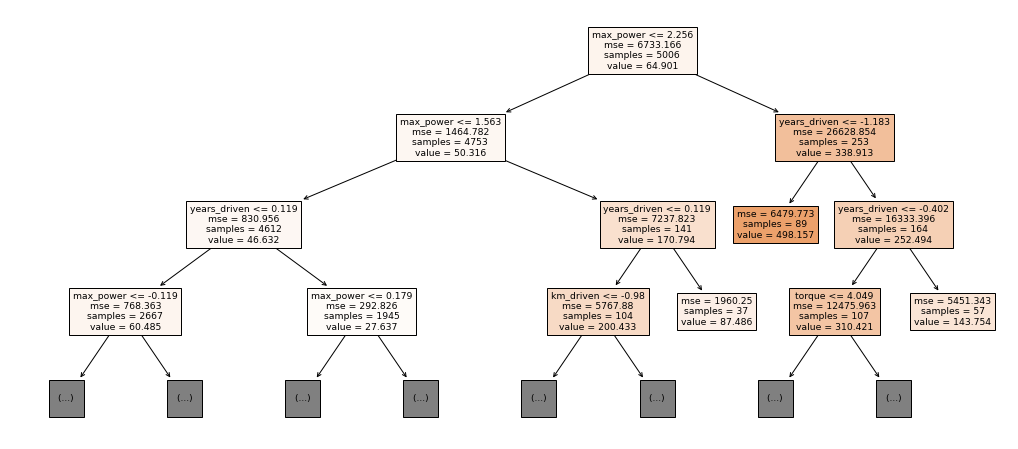

In [243]:
plt.figure(figsize=(18,8))
plot_tree(decisionTree_model.named_steps['reg'], feature_names=list(X.columns), max_depth=3, filled=True);

In [244]:
decisionTree_model.named_steps['reg'].get_n_leaves()

97

## Random forest

Un random forest è un tipo di modello ensemble, che si avvale del bagging come metodo di ensemble e l’albero decisionale come modello individuale.

Il risultato finale restituito dal Random Forest è la media del risultato numerico restituito dai diversi alberi.

Durante l’allenamento, ogni albero in una foresta casuale impara da un campione casuale di punti dati. I campioni vengono disegnati con la sostituzione, nota come bootstrap, il che significa che alcuni campioni verranno utilizzati più volte in un singolo albero.

L’idea è che addestrando ciascun albero su campioni diversi, sebbene ogni albero possa presentare una varianza elevata rispetto a una particolare serie di dati di addestramento, nel complesso l’intera foresta avrà una varianza inferiore ma non a costo di aumentare la distorsione.

Al momento del test, le previsioni vengono effettuate calcolando la media delle previsioni di ciascun albero decisionale (tecnica bagging vista precedentemente). [Come funziona un algoritmo Random Forest?](https://www.lorenzogovoni.com/random-forest/)

In [245]:
from sklearn.ensemble import RandomForestRegressor

In [246]:
# create regressor object
%%time
RandomForestRegressor_model = Pipeline([
    ("scale", StandardScaler()),
    ("reg", RandomForestRegressor(random_state=42))
])
decisionTree_grid = {
    'reg__max_depth': [3, 5, 10, None],
    #"reg__n_estimators": range(10,51,10),
    "reg__min_samples_split": [0.02, 0.05, 0.1]
}

RandomForestRegressor_model, MSE, RE, R2 = grid_search_with_cross_validation(RandomForestRegressor_model, decisionTree_grid, kfold)
print_k_cross_validation_scores(RandomForestRegressor_model, X, y, kfold)
models["RandomForestRegressor_model"] = {"Model" : RandomForestRegressor_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.8970858288618979

                Best params: {'reg__max_depth': None, 'reg__min_samples_split': 0.02}

             Best estimator: Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1,
                                       min_samples_split=0.02,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                

## Riepilogo accuratezze

In [247]:
pd.DataFrame(models)[1:]

,Linear Regression,ElasticNet Regression,KernelRidge poly Regression,KernelRidge rbf Regression,decisionTreeRegressor,RandomForestRegressor_model
MSE,2119.1,2122.54,496.936,305.505,462.77,526.555
relative error,0.793193,0.760459,0.250051,0.224532,0.213117,0.21737
R^2,0.661844,0.661295,0.920701,0.951249,0.926154,0.915975


Per ogni modello visualizziamo i parametri scelti

In [248]:
for name, model in models.items():
  print(name)
  print(model['Model'])
  print('=============================')

Linear Regression
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
ElasticNet Regression
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=0.5, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=42,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)
KernelRidge poly Regression
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=T

# 4- Valutazione dei modelli

Sulla base delle accuratezze individuate scegliamo i modelli che minimizzano gli errori (MSE e l'errore relativo) e che massimizzano l'indice $R^2$. Scegliamo quindi:
* **kernelRidge polinomiale** i cui parametri individuati risultavano:
  - `alpha=10`
  - `degree=3`
* **kernelRidge gaussian radial basis** i cui parametri individuati risultavano:
  - `alpha=0.1`
  - `gamma=0.1`
* **DecisionTreeRegressor** i cui parametri individuati risultavano:
  - `max_depth=None`
  - `min_samples_split=0.02`



In [260]:
def print_eval(X, y, model):
    print("   Mean squared error: {:.5}".format(mean_squared_error(y,model.predict(X))))
    print("       Relative error: {:.5%}".format(relative_error(y,model.predict(X))))
    print("R-squared coefficient: {:.5}".format(model.score(X, y)))


In [262]:
models_name = ['KernelRidge poly Regression','KernelRidge rbf Regression','decisionTreeRegressor']
predictions = []
for num,name in enumerate(models_name,1):
  model = models[name]['Model'].fit(X_train,y_train)
  print(f"{name} model Train")
  print_eval(X_train, y_train, model)
  print("--------------------------------")
  print(f"{name} model Val")
  print_eval(X_val, y_val, model)
  predictions.append({name:model.predict(X_val)})
  
  print("\n================================\n")



KernelRidge poly Regression model Train
   Mean squared error: 388.66
       Relative error: 23.74490%
R-squared coefficient: 0.94228
--------------------------------
KernelRidge poly Regression model Val
   Mean squared error: 496.94
       Relative error: 25.00508%
R-squared coefficient: 0.9207


KernelRidge rbf Regression model Train
   Mean squared error: 323.07
       Relative error: 22.07045%
R-squared coefficient: 0.95202
--------------------------------
KernelRidge rbf Regression model Val
   Mean squared error: 305.51
       Relative error: 22.45320%
R-squared coefficient: 0.95125


decisionTreeRegressor model Train
   Mean squared error: 510.01
       Relative error: 20.26008%
R-squared coefficient: 0.92425
--------------------------------
decisionTreeRegressor model Val
   Mean squared error: 462.77
       Relative error: 21.31174%
R-squared coefficient: 0.92615




Visualizziamo su dei grafici l'analisi del residuo ossia la differenza tra i valori reali e quelli predetti

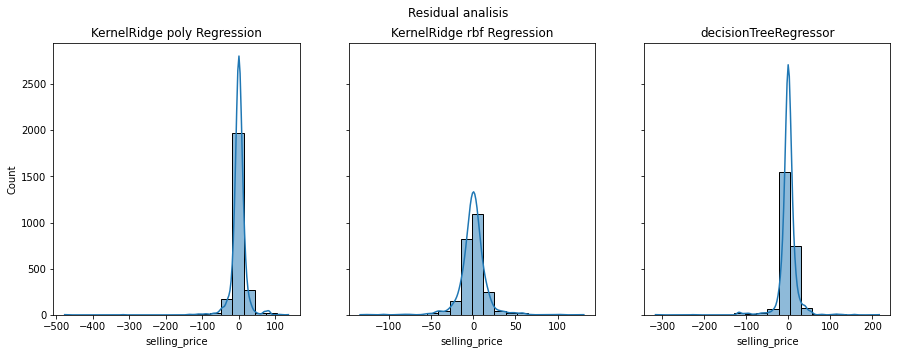

In [289]:
fig, axes = plt.subplots(1,3, figsize=(15, 5), sharey=True)
fig.suptitle('Residual analisis')
for i in range(3):
  sns.histplot((y_val- predictions[i][models_name[i]]),bins=20, ax=axes[i],kde=True)
  axes[i].set_title(models_name[i])

Dai valori ottenuti possiamo vedere come i modelli scelti non soffrono di overfitting, infatti si hanno dei valori simili sia per quanto riguarda i dati di training che quelli di validation. 

Visionando i valori di $R^2$ e i grafici possiamo dire che il modello di tipo KernelRidge rbf è quello con l'accuratezza maggiore e quindi è quello che descrive meglio i dati sebbene l'errore relativo minore lo troviamo nel modello che usa i Decision Tree.



In [251]:
# get importance
importance = models[models_name[2]]['Model'].fit(X_train,y_train).named_steps['reg'].feature_importances_
# summarize feature importance
features = X_train.columns

pd.Series(importance, index=features)


year                            0.007781
km_driven                       0.006427
mileage                         0.002884
engine                          0.002651
max_power                       0.751673
torque                          0.028923
years_driven                    0.199628
fuel_CNG                        0.000000
fuel_LPG                        0.000000
fuel_Petrol                     0.000000
seller_type_Dealer              0.000000
seller_type_Trustmark Dealer    0.000000
transmission_Automatic          0.000000
owner_First Owner               0.000032
owner_Fourth & Above Owner      0.000000
owner_Second Owner              0.000000
owner_Test Drive Car            0.000000
dtype: float64

# Test di verifica

Valutiamo ora i modelli ottenuti sui dati di Test che avevamo precedentemente isolato.

In [252]:
test_data.head()

,year,selling_price,km_driven,mileage,engine,max_power,torque,years_driven,fuel_CNG,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Trustmark Dealer,transmission_Automatic,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car
0,2014,450000,145500,23.40,1248,74.00,190.0,7,0,0,0,0,0,0,1,0,0,0
21,2017,950000,50000,25.50,1498,98.60,200.0,4,0,0,0,0,0,0,1,0,0,0
42,2018,925000,28900,17.80,1497,117.30,145.0,3,0,0,1,1,0,0,1,0,0,0
62,2011,190000,110000,20.36,1197,78.90,111.7,10,0,0,1,0,0,0,0,0,0,0
83,2017,484999,10000,23.10,998,67.04,90.0,4,0,0,1,1,0,0,1,0,0,0


In [254]:
y_test = test_data['selling_price'] //10000
X_test = test_data.drop(columns="selling_price")

for name in models_name:
  model = models[name]['Model'].fit(X_train,y_train)
  print(f"{name} model Test")
  print_eval(X_test, y_test, model)
  
  print("\n================================\n")

KernelRidge poly Regression model Test
   Mean squared error: 449.29
       Relative error: 27.46681%
R-squared coefficient: 0.93995


KernelRidge rbf Regression model Test
   Mean squared error: 399.38
       Relative error: 25.05779%
R-squared coefficient: 0.94662


decisionTreeRegressor model Test
   Mean squared error: 558.6
       Relative error: 22.65833%
R-squared coefficient: 0.92534




Come si può vedere i modelli scelti descrivono molto bene anche i dati nuovi. In particolare RBF è il modello che permette di avere una buona previsione del prezzo di vendita. Tale caratteristica era visibile anche dal confronto tra Training set e validation set.

Ovviamente nessun modello può descrivere perfettamente i dati in quanto il prezzo di vendita può essere sempre soggetto a delle trattative tra venditore e acquirente, ma nel complesso ci si può ritenere soddisfatti dei risultati ottenuti con il modello KernelRidge applicato alla Gaussian Radial Basis.